**Objective:**

Consider the QWorld environment from your first assignment. The objective of this assignment is to design a agent that learn how to solve this problem through the **sarsamax (Q-learning)** and **sarsa** algorithms seen in class

Provide your answers for **PART1** and **PART2** in this notebook and submit it before the due date.

In [ ]:
"""Q Learning to solve a simple world model

Simple deterministic MDP is made of 6 grids (states)
---------------------------------
|         |          |          |
|  Start  |          |  Goal    |
|         |          |          |
---------------------------------
|         |          |          |
|         |          |  Hole    |
|         |          |          |
---------------------------------

"""

from collections import deque
import numpy as np
import argparse
import os
import time
from termcolor import colored


class QWorld:
    def __init__(self):
        """Simulated deterministic world made of 6 states.
        """
        # 4 actions
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        self.col = 4

        # 6 states
        self.row = 6

        # setup the environment
        self.init_transition_table()
        self.init_reward_table()

        # reset the environment
        self.reset()

    def reset(self):
        """start of episode"""
        self.state = 0
        self.count = 0
        return self.state

    def is_in_win_state(self):
        """agent wins when the goal is reached"""
        return self.state == 2


    def init_reward_table(self):
        """
        0 - Left, 1 - Down, 2 - Right, 3 - Up
        ----------------
        | 0 | 0 | 100  |
        ----------------
        | 0 | 0 | -100 |
        ----------------
        """
        self.reward_table = np.zeros([self.row, self.col])
        self.reward_table[1, 2] = 100.
        self.reward_table[4, 2] = -100.


    def init_transition_table(self):
        """
        0 - Left, 1 - Down, 2 - Right, 3 - Up
        -------------
        | 0 | 1 | 2 |
        -------------
        | 3 | 4 | 5 |
        -------------
        """
        self.transition_table = np.zeros([self.row, self.col],
                                         dtype=int)

        self.transition_table[0, 0] = 0
        self.transition_table[0, 1] = 3
        self.transition_table[0, 2] = 1
        self.transition_table[0, 3] = 0

        self.transition_table[1, 0] = 0
        self.transition_table[1, 1] = 4
        self.transition_table[1, 2] = 2
        self.transition_table[1, 3] = 1

        # terminal Goal state
        self.transition_table[2, 0] = 2
        self.transition_table[2, 1] = 2
        self.transition_table[2, 2] = 2
        self.transition_table[2, 3] = 2

        self.transition_table[3, 0] = 3
        self.transition_table[3, 1] = 3
        self.transition_table[3, 2] = 4
        self.transition_table[3, 3] = 0

        self.transition_table[4, 0] = 3
        self.transition_table[4, 1] = 4
        self.transition_table[4, 2] = 5
        self.transition_table[4, 3] = 1

        # terminal Hole state
        self.transition_table[5, 0] = 5
        self.transition_table[5, 1] = 5
        self.transition_table[5, 2] = 5
        self.transition_table[5, 3] = 5


    def step(self, action):
        """execute the action on the environment
        Argument:
            action (tensor): An action in Action space
        Returns:
            next_state (tensor): next env state
            reward (float): reward received by the agent
            done (Bool): whether the terminal state
                is reached
        """
        # determine the next_state given state and action
        next_state = self.transition_table[self.state, action]
        # done is True if next_state is Goal or Hole
        done = next_state == 2 or next_state == 5
        # reward given the state and action
        reward = self.reward_table[self.state, action]
        # the enviroment is now in new state
        self.state = next_state
        self.count+=1
        return next_state, reward, done




    def print_cell(self, row=0):
        """UI to display agent moving on the grid"""
        print("")
        for i in range(13):
            j = i - 2
            if j in [0, 4, 8]:
                if j == 8:
                    if self.state == 2 and row == 0:
                        marker = "\033[4mG\033[0m"
                    elif self.state == 5 and row == 1:
                        marker = "\033[4mH\033[0m"
                    else:
                        marker = 'G' if row == 0 else 'H'
                    color = self.state == 2 and row == 0
                    color = color or (self.state == 5 and row == 1)
                    color = 'red' if color else 'blue'
                    print(colored(marker, color), end='')
                elif self.state in [0, 1, 3, 4]:
                    cell = [(0, 0, 0), (1, 0, 4), (3, 1, 0), (4, 1, 4)]
                    marker = '_' if (self.state, row, j) in cell else ' '
                    print(colored(marker, 'red'), end='')
                else:
                    print(' ', end='')
            elif i % 4 == 0:
                    print('|', end='')
            else:
                print(' ', end='')
        print("")


    def print_world(self, action, step,is_explore):
        """UI to display mode and action of agent"""
        actions = { 0: "(Left)", 1: "(Down)", 2: "(Right)", 3: "(Up)" }
        explore = "Explore" if is_explore else "Exploit"
        print("Step", step, ":", explore, actions[action])
        for _ in range(13):
            print('-', end='')
        self.print_cell()
        for _ in range(13):
            print('-', end='')
        self.print_cell(row=1)
        for _ in range(13):
            print('-', end='')
        print("")




In [ ]:
def print_episode(episode, delay=1):
    """UI to display episode count
    Arguments:
        episode (int): episode number
        delay (int): sec delay

    """
    os.system('clear')
    for _ in range(13):
        print('=', end='')
    print("")
    print("Episode ", episode)
    for _ in range(13):
        print('=', end='')
    print("")
    time.sleep(delay)


def print_status(q_world,q_agent, done, step, delay=1):
    """UI to display the world,
        delay of 1 sec for ease of understanding
    """
    os.system('clear')
    q_world.print_world(action, step,q_agent.is_explore)
    q_agent.print_q_table()
    if done:
        print("-------EPISODE DONE--------")
        delay *= 2
    time.sleep(delay)

# **PART1**: SARSAMAX agent (off-policy)


## a) complete the TODO parts in the cell below in order to design an agent that learns through Q-learning

In [ ]:
import random
class QAgent:
    def __init__(self, col, row, alpha):
        """Q-Learning based agent by Bellman Equation.
        """
        # 4 actions
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        self.col = col

        # 6 states
        self.row = row

        # initialize the q table
        self.q_table = np.zeros([self.row, self.col])

        # discount factor
        self.gamma = 0.9

        # learning rate
        self.alpha = alpha

        # 90% exploration, 10% exploitation
        self.epsilon = 0.9
        # exploration decays by this factor every episode
        self.epsilon_decay = 0.9
        # in the long run, 10% exploration, 90% exploitation
        self.epsilon_min = 0

        # set action model to exploration
        self.is_explore = True

    def act(self, state):
        """determine the next action
            either for Q Table(exploitation) or
            random(exploration)
        Return:
            action (tensor): action that the agent
                must execute
        """
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        # action based on exploration
        if np.random.rand() <= self.epsilon:
            self.is_explore = True
            action=random.randint(0,3)

            ##################################################
            #set exploration mode to true and
            # take random action
            ##################################################

        else:
           self.is_explore = False
           action=np.argmax(self.q_table[state])

            ##################################################
            # set exploration mode to false and
            # take greedy action
            ##################################################


        return action

    def update_q_table(self, state, action, reward, next_state):
        """Q-Learning - update the Q Table using Q(s, a)
        Arguments:
            state (tensor) : agent state
            action (tensor): action executed by the agent
            reward (float): reward after executing action
                for a given state
            next_state (tensor): next state after executing
                action for a given state
        """
        ########################################################
        # update the Q-table with blended Bellman update rule
        ########################################################
        self.q_table[state,action]=(1-self.alpha)*self.q_table[state,action]+self.alpha*(reward+self.gamma*np.max(self.q_table[next_state]))


    def print_q_table(self):
        """UI to dump Q Table contents"""
        print("Q-Table (Epsilon: %0.2f)" % self.epsilon)
        print(self.q_table)

    def update_epsilon(self):
        """update Exploration-Exploitation mix"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



## b) complete the TODO parts in the cell below order to implement a training loop

Recall the steps seen in class:
1. Start with an empty table for $Q(s, a)$.
2. Obtain $(s, a, r, s')$ from the environment.
3. Make a Bellman update: $𝑄(𝑠, 𝑎) ← (1 − 𝛼)𝑄(𝑠, 𝑎) + 𝛼 (𝑟 + 𝛾\max\limits_{x'\in A} Q(s',a'))$
4. Check convergence conditions. If not met, repeat from step 2.

In [ ]:
delay = 0
wins = 0
episode_count = 10000

##################################################
# instantiate an environment q_world
# and an agent called q_agent
##################################################
q_world=QWorld()
q_agent=QAgent(col=q_world.col,row=q_world.row,alpha=0.1)

#count the number of iterations
iterations=0

np.random.seed(5)

for episode in range(episode_count):
    state = q_world.reset()
    done = False
    print_episode(episode, delay=delay)
    while not done:
    ##################################################
    # complete training loop below
    ##################################################
        # choose an action given state
        action = q_agent.act(state)

        # Obtain  next_state, reward, done  from the environment.
        next_state, reward, done = q_world.step(action)

        # update the q-table.
        q_agent.update_q_table(state, action,reward, next_state)

        # update state: the current state becomes the next_state in the next iteration
        state= next_state

        iterations+=1
        # if episode is done:
        if done:
            if q_world.is_in_win_state():
                wins += 1

            percent_wins = 100.0 * wins / (episode + 1)
            print("-------%0.2f%% Goals in %d Episodes---------"
                  % (percent_wins, episode))
            # Exploration-Exploitation is updated every episode
            q_agent.update_epsilon()


    if (episode>100) & (percent_wins>=99.5):
              print("solved in %d iterations" %iterations)
              break

Episode  0
-------100.00% Goals in 0 Episodes---------
Episode  1
-------100.00% Goals in 1 Episodes---------
Episode  2
-------100.00% Goals in 2 Episodes---------
Episode  3
-------100.00% Goals in 3 Episodes---------
Episode  4
-------100.00% Goals in 4 Episodes---------
Episode  5
-------100.00% Goals in 5 Episodes---------
Episode  6
-------100.00% Goals in 6 Episodes---------
Episode  7
-------100.00% Goals in 7 Episodes---------
Episode  8
-------100.00% Goals in 8 Episodes---------
Episode  9
-------100.00% Goals in 9 Episodes---------
Episode  10
-------100.00% Goals in 10 Episodes---------
Episode  11
-------100.00% Goals in 11 Episodes---------
Episode  12
-------100.00% Goals in 12 Episodes---------
Episode  13
-------100.00% Goals in 13 Episodes---------
Episode  14
-------100.00% Goals in 14 Episodes---------
Episode  15
-------100.00% Goals in 15 Episodes---------
Episode  16
-------100.00% Goals in 16 Episodes---------
Episode  17
-------100.00% Goals in 17 Episodes----

### c) Based on the the cell above, when is the problem considered solved? And, after how many iterations the problem was actually solved?

The problem is considered solved once the agent reaches over 100 episodes and has a percent_wins (of reaching the goal) superior or equal to 99.5%. This was done in 257 iterations.

### d) Provide a plot of the percent_wins as a function of the iterations (i.e., iteration number on the x-axis and corresponding percent_wins in the y-axis)

Episode  0
-------0.00% Goals in 0 Episodes---------
Episode  1
-------0.00% Goals in 1 Episodes---------
Episode  2
-------33.33% Goals in 2 Episodes---------
Episode  3
-------50.00% Goals in 3 Episodes---------
Episode  4
-------60.00% Goals in 4 Episodes---------
Episode  5
-------66.67% Goals in 5 Episodes---------
Episode  6
-------71.43% Goals in 6 Episodes---------
Episode  7
-------75.00% Goals in 7 Episodes---------
Episode  8
-------77.78% Goals in 8 Episodes---------
Episode  9
-------80.00% Goals in 9 Episodes---------
Episode  10
-------81.82% Goals in 10 Episodes---------
Episode  11
-------83.33% Goals in 11 Episodes---------
Episode  12
-------84.62% Goals in 12 Episodes---------
Episode  13
-------85.71% Goals in 13 Episodes---------
Episode  14
-------86.67% Goals in 14 Episodes---------
Episode  15
-------87.50% Goals in 15 Episodes---------
Episode  16
-------88.24% Goals in 16 Episodes---------
Episode  17
-------88.89% Goals in 17 Episodes---------
Episode  18
--

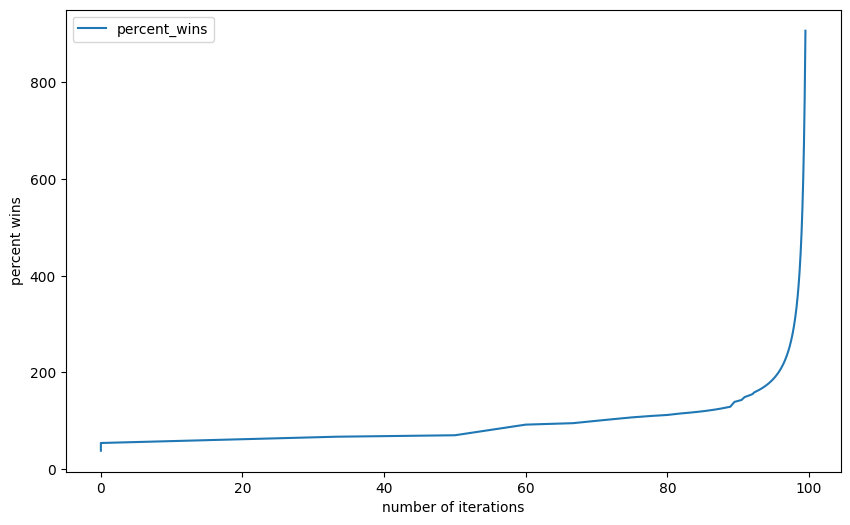

In [ ]:

delay = 0
wins = 0
episode_count = 10000

##################################################
# instantiate an environment q_world
# and an agent called q_agent
##################################################
q_world=QWorld()
q_agent=QAgent(col=q_world.col,row=q_world.row,alpha=0.1)

#count the number of iterations
iterations=0

#initialize iteration and percent_wins lists
iterationList=[]
percentList=[]

np.random.seed(5)

for episode in range(episode_count):
    state = q_world.reset()
    done = False
    print_episode(episode, delay=delay)
    while not done:
    ##################################################
    # complete training loop below
    ##################################################
        # choose an action given state
        action = q_agent.act(state)

        # Obtain  next_state, reward, done  from the environment.
        next_state, reward, done = q_world.step(action)

        # update the q-table.
        q_agent.update_q_table(state, action,reward, next_state)

        # update state: the current state becomes the next_state in the next iteration
        state= next_state

        iterations+=1
        # if episode is done:
        if done:
            if q_world.is_in_win_state():
                wins += 1

            percent_wins = 100.0 * wins / (episode + 1)
            #appending to the list
            percentList.append(percent_wins)
            iterationList.append(iterations)

            print("-------%0.2f%% Goals in %d Episodes---------"
                  % (percent_wins, episode))
            # Exploration-Exploitation is updated every episode
            q_agent.update_epsilon()


    if (episode>100) & (percent_wins>=99.5):
              print("solved in %d iterations" %iterations)
              break





import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(percentList,iterationList, label="percent_wins")
plt.xlabel("number of iterations")
plt.ylabel("percent wins")
plt.legend()
plt.show()



### e) Print the final Q-table (after training loop ends)

In [ ]:
q_agent.print_q_table()

Q-Table (Epsilon: 0.00)
[[  1.03388902   0.48400205  90.           2.76110127]
 [  7.17490836   0.11010779 100.           8.04989511]
 [  0.           0.           0.           0.        ]
 [  0.           0.22122992   0.          15.24185905]
 [  1.82743418   0.         -19.           0.        ]
 [  0.           0.           0.           0.        ]]


### f) Based on this final table, what is the best action to take if the agent is in state 3?

As the Q-table has converged, we can exploit it to decide which is the best action to take while being in the state 3. The best action is going up to the state 0.


$(𝑄(3, 𝑎)) ← (1 − 𝛼)𝑄(3, 𝑎) + 𝛼 (𝑟 + 𝛾\max\limits_{x'\in A} Q((0,up),(4,right))$


with:


*   alpha= 0.1
*   Q(0, up)= 90
*   Q(4, right)= -19
*   gamma = 0.9
*   reward r= 0

In [ ]:
"""
          0 - Left, 1 - Down, 2 - Right, 3 - Up
          -------------
          | 0 | 1 | 2 |
          -------------
          | 3 | 4 | 5 |
          -------------
"""

### g) Finally, now use your trained agent in 20 episodes-- full exploitation
### Use `print_status` for showing episode results

### Then, provide a plot that shows whether the agent reached the goal or not as a function of the episodes (i.e, x-axis is episode number, y-axis: 1 if goal reached, 0 otherwise)

### Comment on the obtained results.
### What is the percent wins  for these 20 episodes?

Episode  0
-------100.00% Goals in 0 Episodes---------
Step 2 : Exploit (Right)
-------------
|   |   | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.00)
[[  1.03388902   0.48400205  90.           2.76110127]
 [  7.17490836   0.11010779 100.           8.04989511]
 [  0.           0.           0.           0.        ]
 [  0.           0.22122992   0.          15.24185905]
 [  1.82743418   0.         -19.           0.        ]
 [  0.           0.           0.           0.        ]]
-------EPISODE DONE--------
Percent wins over 20 episodes 100.0 %
Episode  1
-------100.00% Goals in 1 Episodes---------
Step 2 : Exploit (Right)
-------------
|   |   | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.00)
[[  1.03388902   0.48400205  90.           2.76110127]
 [  7.17490836   0.11010779 100.           8.04989511]
 [  0.           0.           0.           0.        ]
 [  0.           0.22122992   0.          15.24185905]
 [  1.82743418   0.         -19.   

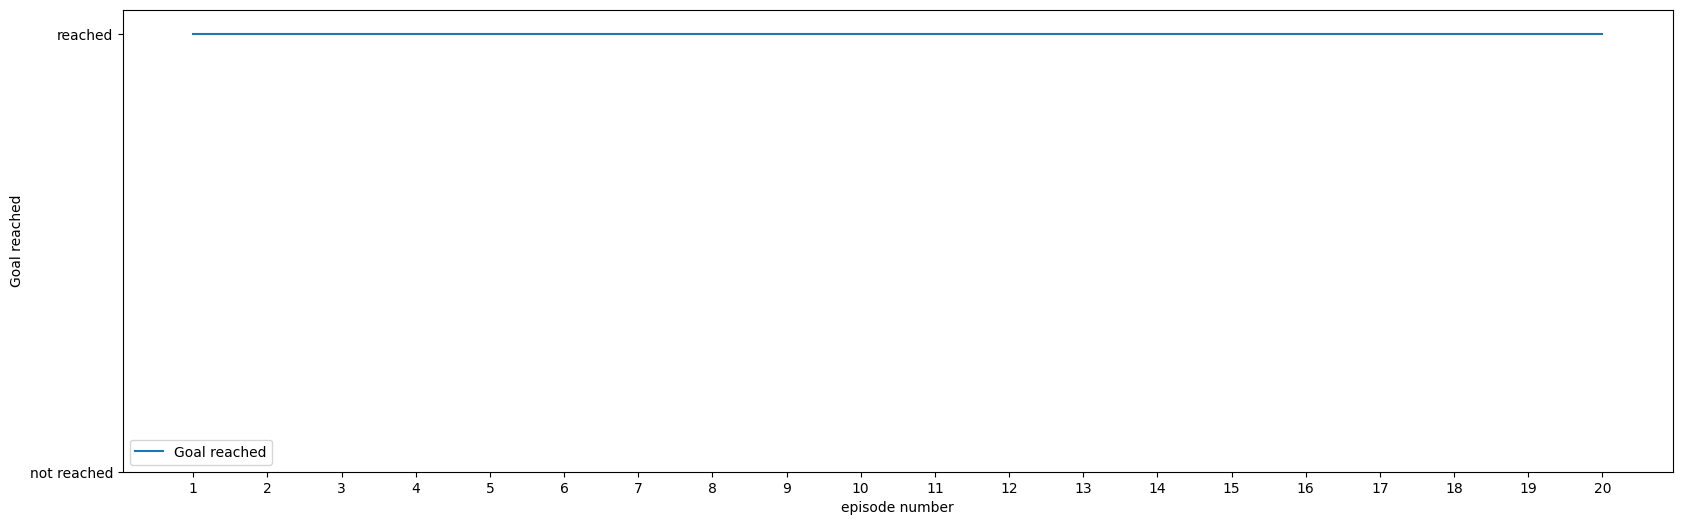

In [ ]:

delay = 0
wins = 0
episode_count = 20

#use the trained agent in full exploitation mode
q_agent.epsilon=0


#count the number of iterations
iterations=0
goals_reached=[]

np.random.seed(5)

for episode in range(episode_count):
    state = q_world.reset()
    done = False
    print_episode(episode, delay=delay)
    goal_reached= 0
    step=0
    while not done:

        # choose an action given state
        action = q_agent.act(state)

        # Obtain  next_state, reward, done  from the environment.
        next_state, reward, done = q_world.step(action)

        # update the q-table.
        #q_agent.update_q_table(state, action,reward, next_state)

        # update state: the current state becomes the next_state in the next iteration
        state= next_state

        step+=1

        iterations+=1
        # if episode is done:
        if done:
            if q_world.is_in_win_state():
                wins += 1
                goal_reached=1
            goals_reached.append(goal_reached)

            percent_wins = 100.0 * wins / (episode + 1)

            print("-------%0.2f%% Goals in %d Episodes---------"
                  % (percent_wins, episode))

    print_status(q_world,q_agent,done,step,delay=delay)
    percent_wins_20eps=100 * sum(goals_reached) / len(goals_reached)
    print("Percent wins over 20 episodes",percent_wins_20eps,"%")






import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.plot(range(1,episode_count+1),goals_reached, label="Goal reached")
plt.xlabel("episode number")
plt.ylabel("Goal reached")
plt.xticks(range(1,episode_count+1))
plt.yticks([0,1],labels=['not reached','reached'])
plt.legend()
plt.show()



# **PART2**: SARSA-based agent (ON-policy)
# In this part, you need to implement an agent that learns how to solve this problem with the on-policy sarsa algorithm. Re-answer all the questions as in part A):  from a) to g)


## a) Designing an agent that learns through Q-learning (Sarsa-based)

In [ ]:
import random
class QAgent1:
    def __init__(self, col, row, alpha):
        """Q-Learning based agent by SARSA.
        """
        # 4 actions
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        self.col = col

        # 6 states
        self.row = row

        # initialize the q table
        self.q_table = np.zeros([self.row, self.col])

        # discount factor
        self.gamma = 0.9

        # learning rate
        self.alpha = alpha

        # 90% exploration, 10% exploitation
        self.epsilon = 0.9
        # exploration decays by this factor every episode
        self.epsilon_decay = 0.9
        # in the long run, 10% exploration, 90% exploitation
        self.epsilon_min = 0

        # set action model to exploration
        self.is_explore = True

    def act(self, state):
        """determine the next action
            either for Q Table(exploitation) or
            random(exploration)
        Return:
            action (tensor): action that the agent
                must execute
        """
        # 0 - Left, 1 - Down, 2 - Right, 3 - Up
        # action based on exploration
        if np.random.rand() <= self.epsilon:
            self.is_explore = True
            action=random.randint(0,3)

            ##################################################
            #set exploration mode to true and
            # take random action
            ##################################################

        else:
           self.is_explore = False
           action=np.argmax(self.q_table[state])

            ##################################################
            # set exploration mode to false and
            # take greedy action
            ##################################################


        return action

    def update_q_table(self, state, action, reward, next_state,next_action):
        """Q-Learning_SARSA - update the Q Table using the on-policy rule Q(s,a)=Q(s,a)+ alpha * (reward+ gamma * Q(s',a')-Q(s,a))
        Arguments:
            state (tensor) : agent state
            action (tensor): action executed by the agent
            reward (float): reward after executing action
                for a given state
            next_state (tensor): next state after executing
                action for a given state
        """
        ########################################################
        # update the Q-table with SARSA update rule
        ########################################################
        self.q_table[state,action]+=self.alpha*(reward+self.gamma*(self.q_table[next_state,next_action])-self.q_table[state,action])


    def print_q_table(self):
        """UI to dump Q Table contents"""
        print("Q-Table (Epsilon: %0.2f)" % self.epsilon)
        print(self.q_table)

    def update_epsilon(self):
        """update Exploration-Exploitation mix"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



## b) Implementing a training loop

Recall the steps seen in class:
1. Start with an empty table for $Q(s, a)$.
2. Obtain $(s, a, r, s')$ from the environment.
3. Make a SARSA update: $𝑄(𝑠, 𝑎) ← 𝑄(𝑠, 𝑎) + 𝛼 (𝑟 + 𝛾Q(s',a') - Q(s,a))$
4. Check convergence conditions. If not met, repeat from step 2.

In [ ]:
delay = 0
wins = 0
episode_count = 10000

##################################################
# instantiate an environment q_world
# and an agent called q_agent1
##################################################
q_world=QWorld()
q_agent1=QAgent1(col=q_world.col,row=q_world.row,alpha=0.1)

#count the number of iterations
iterations=0

np.random.seed(5)

for episode in range(episode_count):
    state = q_world.reset()
    done = False
    print_episode(episode, delay=delay)
    while not done:
    ##################################################
    # complete training loop below
    ##################################################
        # choose an action given state
        action = q_agent1.act(state)

        # Obtain  next_state, reward, done  from the environment.
        next_state, reward, done = q_world.step(action)

        # choose the next action given the next state
        next_action = q_agent1.act(next_state)

        # update the q-table.
        q_agent1.update_q_table(state, action,reward, next_state, next_action)

        # update state and action: the current state becomes the next_state and action becomes next_action in the next iteration
        state= next_state
        action= next_action

        iterations+=1
        # if episode is done:
        if done:
            if q_world.is_in_win_state():
                wins += 1

            percent_wins = 100.0 * wins / (episode + 1)
            print("-------%0.2f%% Goals in %d Episodes---------"
                  % (percent_wins, episode))
            # Exploration-Exploitation is updated every episode
            q_agent1.update_epsilon()


    if (episode>100) & (percent_wins>=99.5):
              print("solved in %d iterations" %iterations)
              break



Episode  0
-------100.00% Goals in 0 Episodes---------
Episode  1
-------50.00% Goals in 1 Episodes---------
Episode  2
-------66.67% Goals in 2 Episodes---------
Episode  3
-------75.00% Goals in 3 Episodes---------
Episode  4
-------80.00% Goals in 4 Episodes---------
Episode  5
-------83.33% Goals in 5 Episodes---------
Episode  6
-------85.71% Goals in 6 Episodes---------
Episode  7
-------87.50% Goals in 7 Episodes---------
Episode  8
-------88.89% Goals in 8 Episodes---------
Episode  9
-------90.00% Goals in 9 Episodes---------
Episode  10
-------90.91% Goals in 10 Episodes---------
Episode  11
-------91.67% Goals in 11 Episodes---------
Episode  12
-------92.31% Goals in 12 Episodes---------
Episode  13
-------92.86% Goals in 13 Episodes---------
Episode  14
-------93.33% Goals in 14 Episodes---------
Episode  15
-------93.75% Goals in 15 Episodes---------
Episode  16
-------94.12% Goals in 16 Episodes---------
Episode  17
-------94.44% Goals in 17 Episodes---------
Episode  18

### c) Based on the the cell above, when is the problem considered solved? And, after how many iterations the problem was actually solved?

The problem is considered solved once the agent reaches over 100 episodes and has a percent_wins (of reaching the goal) superior or equal to 99.5%. This was done in 433 iterations.

### d) Provide a plot of the percent_wins as a function of the iterations (i.e., iteration number on the x-axis and corresponding percent_wins in the y-axis)

Episode  0
-------0.00% Goals in 0 Episodes---------
Episode  1
-------50.00% Goals in 1 Episodes---------
Episode  2
-------66.67% Goals in 2 Episodes---------
Episode  3
-------75.00% Goals in 3 Episodes---------
Episode  4
-------80.00% Goals in 4 Episodes---------
Episode  5
-------83.33% Goals in 5 Episodes---------
Episode  6
-------85.71% Goals in 6 Episodes---------
Episode  7
-------87.50% Goals in 7 Episodes---------
Episode  8
-------88.89% Goals in 8 Episodes---------
Episode  9
-------90.00% Goals in 9 Episodes---------
Episode  10
-------90.91% Goals in 10 Episodes---------
Episode  11
-------91.67% Goals in 11 Episodes---------
Episode  12
-------92.31% Goals in 12 Episodes---------
Episode  13
-------92.86% Goals in 13 Episodes---------
Episode  14
-------93.33% Goals in 14 Episodes---------
Episode  15
-------93.75% Goals in 15 Episodes---------
Episode  16
-------94.12% Goals in 16 Episodes---------
Episode  17
-------94.44% Goals in 17 Episodes---------
Episode  18
-

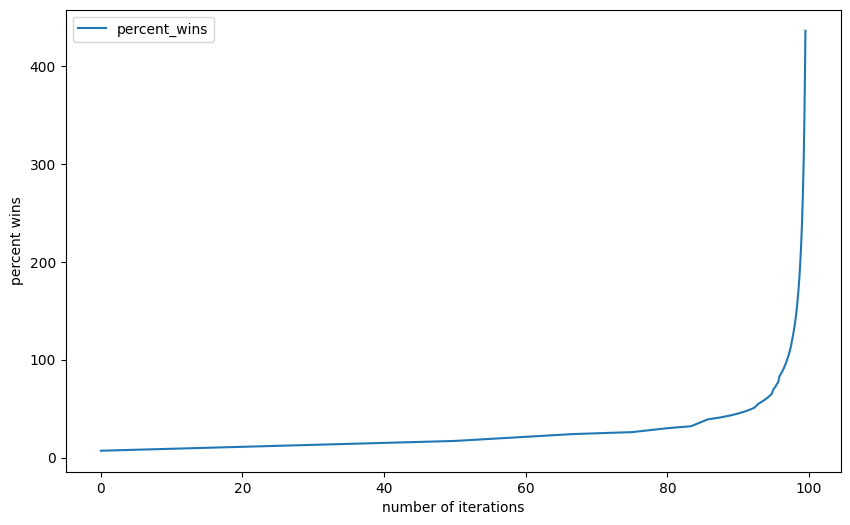

In [ ]:
delay = 0
wins = 0
episode_count = 10000

##################################################
# instantiate an environment q_world
# and an agent called q_agent
##################################################
q_world=QWorld()
q_agent1=QAgent1(col=q_world.col,row=q_world.row,alpha=0.1)

#count the number of iterations
iterations=0

#initialize the iterations and percent_wins lists
percentList=[]
iterationList=[]


np.random.seed(5)

for episode in range(episode_count):
    state = q_world.reset()
    done = False
    print_episode(episode, delay=delay)
    while not done:
    ##################################################
    # complete training loop below
    ##################################################
        # choose an action given state
        action = q_agent1.act(state)

        # Obtain  next_state, reward, done  from the environment.
        next_state, reward, done = q_world.step(action)

        # choose the next action given the next state
        next_action = q_agent1.act(next_state)

        # update the q-table.
        q_agent1.update_q_table(state, action,reward, next_state, next_action)

        # update state and action: the current state becomes the next_state and action becomes next_action in the next iteration
        state= next_state
        action= next_action

        iterations+=1

        # if episode is done:
        if done:
            if q_world.is_in_win_state():
                wins += 1

            percent_wins = 100.0 * wins / (episode + 1)

            iterationList.append(iterations)
            percentList.append(percent_wins)

            print("-------%0.2f%% Goals in %d Episodes---------"
                  % (percent_wins, episode))
            # Exploration-Exploitation is updated every episode
            q_agent1.update_epsilon()


    if (episode>100) & (percent_wins>=99.5):
              print("solved in %d iterations" %iterations)
              break




import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(percentList,iterationList, label="percent_wins")
plt.xlabel("number of iterations")
plt.ylabel("percent wins")
plt.legend()
plt.show()


### e) Print the final Q-table (after training loop ends)

In [ ]:
q_agent1.print_q_table()

Q-Table (Epsilon: 0.00)
[[ 11.20098767   0.          89.99999837   4.69326484]
 [  0.          -0.81        99.99999992  14.53338174]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           7.76483394]
 [  0.23876432   0.         -10.           0.        ]
 [  0.           0.           0.           0.        ]]


### f) Based on this final table, what is the best action to take if the agent is in state 3?

As the Q-table has converged, we can exploit it to decide which is the best action to take while being in the state 3. The best action is going up (action 4) to the state 0.

$max(Q(3,a))= Q(3,4)= 7.76483394 $



g) Finally, now use your trained agent in 20 episodes-- full exploitation
### Use `print_status` for showing episode results

### Then, provide a plot that shows whether the agent reached the goal or not as a function of the episodes (i.e, x-axis is episode number, y-axis: 1 if goal reached, 0 otherwise)

### Comment on the obtained results.
### What is the percent wins  for these 20 episodes?

Episode  0
-------100.00% Goals in 0 Episodes---------
Step 2 : Exploit (Right)
-------------
|   |   | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.00)
[[  2.69675243   0.          90.           2.50389268]
 [  5.64169883  -1.3346379  100.           9.48339408]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.75489489   0.        ]
 [  0.           0.         -19.          13.72465354]
 [  0.           0.           0.           0.        ]]
-------EPISODE DONE--------
Percent wins over 20 episodes 100.0 %
Episode  1
-------100.00% Goals in 1 Episodes---------
Step 2 : Exploit (Right)
-------------
|   |   | G |
-------------
|   |   | H |
-------------
Q-Table (Epsilon: 0.00)
[[  2.69675243   0.          90.           2.50389268]
 [  5.64169883  -1.3346379  100.           9.48339408]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.75489489   0.        ]
 [  0.           0.         -19.   

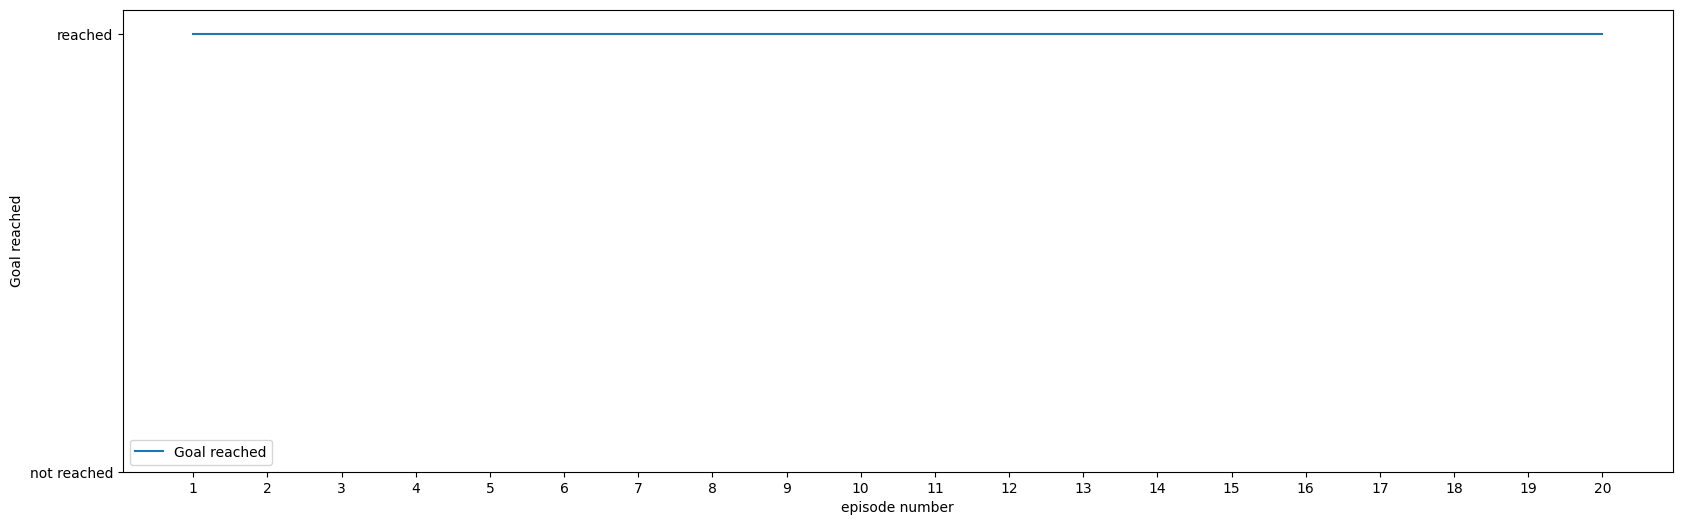

In [ ]:

delay = 0
wins = 0
episode_count = 20

#use the trained agent in full exploitation mode
q_agent1.epsilon=0


#count the number of iterations
iterations=0
goals_reached=[]

np.random.seed(5)

for episode in range(episode_count):
    state = q_world.reset()
    done = False
    print_episode(episode, delay=delay)
    goal_reached= 0
    step=0
    while not done:

        # choose an action given state
        action = q_agent1.act(state)

        # Obtain  next_state, reward, done  from the environment.
        next_state, reward, done = q_world.step(action)

        # update the q-table.
        #q_agent.update_q_table(state, action,reward, next_state)

        # update state: the current state becomes the next_state in the next iteration
        state= next_state

        step+=1

        iterations+=1
        # if episode is done:
        if done:
            if q_world.is_in_win_state():
                wins += 1
                goal_reached=1
            goals_reached.append(goal_reached)

            percent_wins = 100.0 * wins / (episode + 1)

            print("-------%0.2f%% Goals in %d Episodes---------"
                  % (percent_wins, episode))

    print_status(q_world,q_agent1,done,step,delay=delay)
    percent_wins_20eps=100 * sum(goals_reached) / len(goals_reached)
    print("Percent wins over 20 episodes",percent_wins_20eps,"%")






import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.plot(range(1,episode_count+1),goals_reached, label="Goal reached")
plt.xlabel("episode number")
plt.ylabel("Goal reached")
plt.xticks(range(1,episode_count+1))
plt.yticks([0,1],labels=['not reached','reached'])
plt.legend()
plt.show()

